In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from pykrige import OrdinaryKriging

import os

## Data reading    
 - [ ] read origin data
 - [ ] read baikal obris
 - [ ] read baikal normalazed matrix 

In [3]:
plt.style.use('Solarize_Light2')   # try another styles: 'classic', 'Solarize_Light2'
driver = "G:/"   # "~/"
pwd = os.path.join(driver, '1_Data1/sea/')
srcDataPath = os.path.join(pwd, "AllSea.txt")
obrisDataPath = os.path.join(driver, "1_Data1/obris/obris.dat")
batimetrFilePath = os.path.join(driver, "1_Data1/batimetria/b1.txt")
# srcData = "~/methaneSea.dat
srcDataPath

'G:/1_Data1/sea/AllSea.txt'

In [4]:
obris = pd.read_csv(obrisDataPath,
                    header=0,
                    na_values='--',
                    sep='\t',
                    decimal=',',
                   )

In [5]:
## set grid
longStep = 0.02
latStep = 0.01

In [6]:
gdf = pd.read_csv('wholeBaikalGrid.dat', sep='\t')
gdf.drop('Unnamed: 0', axis='columns', inplace=True)
gdf['long'] = ((gdf['long']/longStep).round()*longStep*1000).round().astype('int')
gdf['lat'] = ((gdf['lat']/latStep).round()*latStep*1000).round().astype('int')
gdf['Longitude'] = gdf['long']/1000
gdf['Latitude'] = gdf['lat']/1000
gdf['norm_x'] = (gdf['toWest']/(gdf['toWest'] + gdf['toEast'])*25).astype('int')
gdf['norm_y'] = (gdf['toSud']/(gdf['toSud'] + gdf['toNord'])*400).astype('int')

gdf.loc[(gdf['long']==104000) & (gdf['lat']==51630), :]

,long,lat,toWest,toEast,toSud,toNord,norm_x,norm_y,cCH4wtr,Longitude,Latitude
638,104000,51630,13.481916,4.532593,21.456877,595.738497,18,13,130.518905,104.0,51.63
639,104000,51630,12.936204,4.952544,21.222809,595.296580,18,13,138.062133,104.0,51.63
675,104000,51630,13.629061,5.023539,22.081760,595.319667,18,14,131.860302,104.0,51.63
676,104000,51630,13.089468,5.410384,21.854317,594.877486,17,14,142.635559,104.0,51.63


In [16]:
df = pd.read_csv(os.path.join(pwd, "all.txt"),  #"AllSea.txt"
                 header=0,
                 # usecols=['Longitude', 'Latitude', 'DateTime', 'cCH4Wtr', 'cCO2Wtr', 'dpCO2', 'dpCH4', ],
                 # skip_blank_lines=True,
                 skipinitialspace=True,
                 na_values='',
                 skiprows=[],
                 sep='\t',
                 decimal='.',
                 #nrows=5000,
                 parse_dates=['DateTime'],
                 dayfirst=False
                 )

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134021 entries, 0 to 134020
Data columns (total 47 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Unnamed: 0     134021 non-null  int64         
 1   DateTime       134021 non-null  datetime64[ns]
 2   Longitude      134021 non-null  float64       
 3   Latitude       134021 non-null  float64       
 4   TempAir        120255 non-null  float64       
 5   PressAir       129633 non-null  float64       
 6   TempWtr        88128 non-null   float64       
 7   pCO2Air        95711 non-null   float64       
 8   pCH4Air        86464 non-null   float64       
 9   pCO2Wtr        88233 non-null   float64       
 10  pCH4Wtr        87022 non-null   float64       
 11  dpCO2          88763 non-null   float64       
 12  dpCH4          56916 non-null   float64       
 13  cCO2Wtr        88146 non-null   float64       
 14  cCH4Wtr        86191 non-null   float64       
 15  

In [9]:
df['year'] = df['DateTime'].dt.year

In [10]:
df.reset_index(drop=True, inplace=True)

In [18]:
## what to study
paramName = 'TempWtr'

In [19]:
## check for bad data
df.dropna(subset=[paramName]).sort_values(by=paramName).tail(2)

,Unnamed: 0,DateTime,Longitude,Latitude,TempAir,PressAir,TempWtr,pCO2Air,pCH4Air,pCO2Wtr,...,Wh,Wdir,vx,vy,vesx,vesy,dateSec,dt,vesSpeed,winSpeed
85776,87337,2022-06-10 17:08:00,109.369905,55.649393,27.320000,96025.500000,18.94,394.386042,1.906213,NaN,...,1.046,95.9,0.096,0.930,-0.52300,-0.556131,1.654881e+09,60.0,0.012724,0.944162
85775,87336,2022-06-10 17:07:00,109.369913,55.649398,27.246667,96022.466667,18.94,394.357390,1.906097,NaN,...,1.720,107.3,0.492,1.576,-1.10876,-0.444905,1.654881e+09,60.0,0.019912,1.658091


In [20]:
for yr in range(2013, 2025):
    t = df.loc[(df['year'] == yr) & df[paramName]].shape
    print(f'{yr}: {t[0]}')

2013: 11449
2014: 0
2015: 0
2016: 10726
2017: 15170
2018: 16201
2019: 0
2020: 0
2021: 16880
2022: 17702
2023: 0
2024: 0


In [21]:
df['long'] = ((df['Longitude']/longStep).round()*longStep*1000).round().astype('int')
df['lat'] = ((df['Latitude']/latStep).round()*latStep*1000).round().astype('int')
df

,Unnamed: 0,DateTime,Longitude,Latitude,TempAir,PressAir,TempWtr,pCO2Air,pCH4Air,pCO2Wtr,...,CH4_dry,CO2_dry,vCO2Air,vCH4Air,pCO2,pCH4,depth,year,long,lat
0,0,2013-05-28 22:00:38,104.649879,51.781395,NaN,NaN,3.0,402.425575,NaN,464.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-1423.179,2013,104640,51780
1,1,2013-05-28 22:01:38,104.649879,51.781395,NaN,NaN,3.0,402.425706,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1423.179,2013,104640,51780
2,2,2013-05-28 22:02:38,104.649879,51.781395,NaN,NaN,3.0,402.425837,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1423.179,2013,104640,51780
3,3,2013-05-28 22:03:38,104.649879,51.781395,NaN,NaN,3.0,402.425968,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1423.179,2013,104640,51780
4,4,2013-05-28 22:04:38,104.649879,51.781395,NaN,NaN,3.0,402.426099,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1423.179,2013,104640,51780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445731,445731,2024-06-12 19:16:20,105.044195,51.878914,18.06,0.945167,NaN,398.430013,1.896581,NaN,...,NaN,NaN,421.544770,2.00661,398.689788,1.898499,-483.560,2024,105040,51880
445732,445732,2024-06-12 19:16:40,105.043188,51.878469,18.10,0.945124,NaN,398.481455,1.896495,NaN,...,NaN,NaN,421.618126,2.00661,398.050635,1.897455,-483.560,2024,105040,51880
445733,445733,2024-06-12 19:17:00,105.042178,51.878013,18.12,0.945118,NaN,398.339389,1.896484,NaN,...,NaN,NaN,421.470453,2.00661,398.300636,1.898402,-483.560,2024,105040,51880
445734,445734,2024-06-12 19:17:20,105.041126,51.877511,18.06,0.945102,NaN,398.161076,1.896452,NaN,...,NaN,NaN,421.288824,2.00661,398.147755,1.897411,-483.560,2024,105040,51880


In [22]:
#funcList = ['mean', 'count']
funcList = ['mean']
cols_to_calc = {#'cCH4Wtr': funcList,
                #'cCO2Wtr': funcList,
                # 'dpCO2': funcList,
                #'dpCH4': funcList,
                paramName: funcList
               }
res = df.groupby(['year', 'long', 'lat'], as_index=False).agg(cols_to_calc)
res.columns = res.columns.get_level_values(0)
res

,year,long,lat,cCO2Wtr
0,2013,103880,51670,1.489429
1,2013,103880,51680,1.487019
2,2013,103900,51670,1.482716
3,2013,103900,51680,1.369224
4,2013,103920,51660,1.462885
...,...,...,...,...
16967,2024,109820,55540,NaN
16968,2024,109820,55690,1.373390
16969,2024,109820,55700,1.417259
16970,2024,109840,55700,1.331032


In [23]:
res = pd.merge(left=res, right=gdf, left_on=['long', 'lat'], right_on=['long', 'lat'], how='left')

In [24]:
res['norm_x'] = res['toWest']/(res['toWest'] + res['toEast'])
res['norm_y'] = res['toSud']/(res['toSud'] + res['toNord'])
res = res.dropna(subset=[paramName, 'norm_x', 'norm_y'])

In [25]:
res.describe()

,year,long,lat,cCO2Wtr,toWest,toEast,toSud,toNord,norm_x,norm_y,cCH4wtr,Longitude,Latitude
count,54673.000000,54673.000000,54673.000000,54673.000000,54673.000000,54673.000000,54673.000000,54673.000000,54673.000000,54673.000000,54673.000000,54673.000000,54673.000000
mean,2019.623763,107558.222523,53388.198745,1.119209,23.015245,23.249262,324.271373,302.706789,0.475455,0.519690,234.074946,107.558223,53.388199
std,3.543897,1646.681428,1202.284481,0.311173,18.047661,14.637208,161.440722,167.235294,0.291305,0.265075,345.791492,1.646681,1.202284
min,2013.000000,103760.000000,51500.000000,0.113051,0.023253,0.063622,2.949150,2.376518,0.001442,0.004896,75.868379,103.760000,51.500000
25%,2017.000000,106180.000000,52460.000000,0.941725,7.709482,11.093424,185.161895,160.383946,0.214291,0.297979,115.556131,106.180000,52.460000
50%,2021.000000,107960.000000,53310.000000,1.126525,18.655967,22.222227,332.586719,300.332413,0.468446,0.524076,144.354854,107.960000,53.310000
75%,2023.000000,109000.000000,54390.000000,1.282378,33.351735,32.258240,458.254001,435.091399,0.734326,0.741148,214.984771,109.000000,54.390000
max,2024.000000,109860.000000,55770.000000,3.436452,75.836224,66.361879,600.522704,600.702656,0.998281,0.996045,4574.096361,109.860000,55.770000


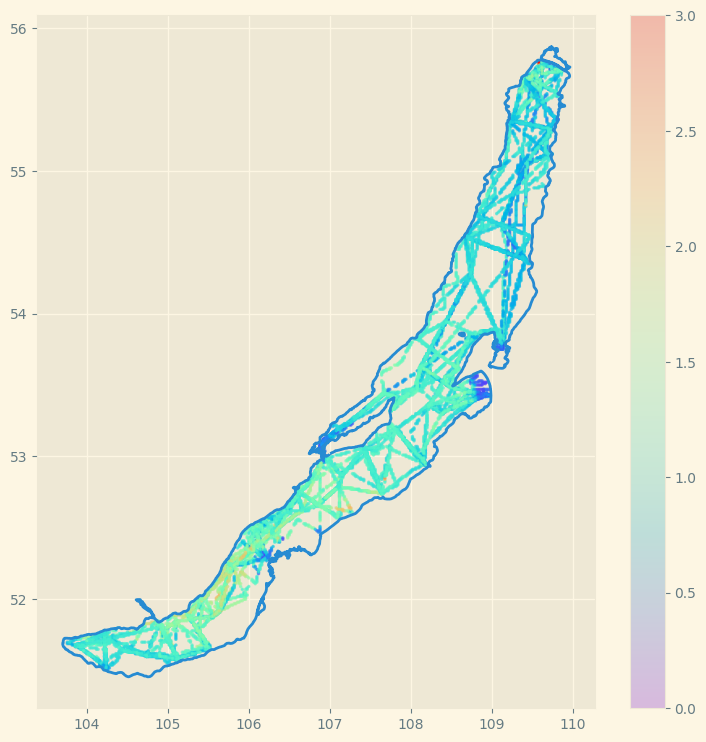

In [27]:
plt.rcParams['figure.figsize'] = [9, 9]

plt.scatter(res['long']/1000, res['lat']/1000, c=res[paramName], cmap='rainbow', s=2, alpha=0.2)
plt.colorbar()
plt.clim(0, 3)
#plt.xlim(103.6, 105)
#plt.ylim(51.4, 52)
plt.plot('long', 'lat', data=obris)

In [ ]:
lat = res['norm_y'].values
long = res['norm_x'].values
dpCO2 = res['dpCO2'].values
gridx = np.linspace(0, 1, 25)
gridy = np.linspace(0, 1, 400)

In [ ]:
plt.rcParams['figure.figsize'] = [3, 3]
ok = OrdinaryKriging(long,
                     lat,
                     dpCO2,
                     variogram_model='spherical',
                     coordinates_type='geographic',
                     verbose=True,
                     enable_plotting=True)

In [ ]:
z_interp, ss = ok.execute('grid', gridx, gridy)

In [ ]:
z_interp.data.shape

In [ ]:
surdf = pd.DataFrame([[y, x, z_interp[x, y]] for x in range(400) for y in range(25)], columns=['norm_x', 'norm_y', 'dpCO2All'])

In [ ]:
plt.rcParams['figure.figsize'] = [3, 10]
plt.scatter('norm_x', 'norm_y', data=surdf, c=surdf['dpCO2All'], cmap='rainbow')
plt.colorbar()

In [ ]:
gdf = pd.merge(left=gdf, right=surdf, left_on=['norm_x', 'norm_y'], right_on=['norm_x', 'norm_y'], how='left')

In [ ]:
gdf

In [ ]:
plt.rcParams['figure.figsize'] = [12, 12]

plt.scatter('Longitude', 'Latitude', data=gdf, c=gdf['dpCO2All'], cmap='rainbow', s=20, alpha=0.5, linewidth=0)
plt.clim(-200, 200)
plt.colorbar(alpha=1)
plt.scatter('Longitude', 'Latitude', data=df, c=df['dpCO2'], cmap='rainbow', s=5, alpha=0.1, linewidth=0)
plt.clim(-200, 200)
plt.xlim(103.6, 110)
plt.ylim(51.2, 56)
plt.plot('long', 'lat', data=obris, alpha=0.5, linewidth=0.5)
plt.fill('long', 'lat', data=obris.iloc[4845:,:], c='white', alpha=1, linewidth=0.5)
plt.title(f'dpCO2 Jul-Aug 2024, mkatm')
plt.savefig(f'surf_dpCO2_jul2024.png')


In [ ]:
#for year in [2013, 2016, 2017, 2018, 2021, 2022, 2023, 2024]:
for year in [2024]:
    lat = res.loc[res['year']==year,'norm_y'].values
    long = res.loc[res['year']==year,'norm_x'].values
    value = res.loc[res['year']==year,'dpCO2'].values
    gridx = np.linspace(0, 1, 25)
    gridy = np.linspace(0, 1, 400)
    
    ok = OrdinaryKriging(long,
                         lat,
                         value,
                         variogram_model='spherical',
                         coordinates_type='geographic',
                         verbose=False,
                         enable_plotting=False)
    z_interp, ss = ok.execute('grid', gridx, gridy)
    
    surdf = pd.DataFrame([[y, x, z_interp[x, y]] for x in range(400) for y in range(25)], columns=['norm_x', 'norm_y', f'dpCO2{year}'])
    gdf = pd.merge(left=gdf, right=surdf, left_on=['norm_x', 'norm_y'], right_on=['norm_x', 'norm_y'], how='left')

In [ ]:
cycles=['dpCO22013', 'dpCO22016', 'dpCO22017', 'dpCO22018', 'dpCO22021', 'dpCO22022', 'dpCO22023', 'dpCO22024']
gdf['dpCO2All']=0
for cycle in cycles:
    gdf['dpCO2All'] += gdf[cycle]
gdf['dpCO2All']/=len(cycles)
gdf

In [ ]:
gdf.to_csv(os.path.join(pwd, 'pdCO2Surfer.txt'), sep='\t')

In [ ]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 12]

In [ ]:
cycles=['dpCO2All', 'dpCO22013', 'dpCO22016', 'dpCO22017', 'dpCO22018', 'dpCO22021', 'dpCO22022', 'dpCO22023', 'dpCO22024']
cycles=['All', 2013, 2016, 2017, 2018, 2021, 2022, 2023, 2024]
for cycle in cycles:
    if cycle == 'All':
        plt.scatter('Longitude', 'Latitude', data=df, c=df['dpCO2'], cmap='rainbow', s=5, alpha=0.1, linewidth=0)
    else:
        plt.scatter('Longitude', 'Latitude', data=df.loc[df['year']==cycle,:], c=df.loc[df['year']==cycle,'dpCO2'], cmap='rainbow', s=5, alpha=0.3, linewidth=0)
    plt.clim(-200, 200)
    plt.scatter('Longitude', 'Latitude', data=gdf, c=gdf[f'dpCO2{cycle}'], cmap='rainbow', s=5, alpha=0.5, linewidth=0)
    plt.colorbar(alpha=1)
    plt.clim(-200, 200)
    plt.xlim(103.6, 110)
    plt.ylim(51.2, 56)
    plt.plot('long', 'lat', data=obris, alpha=0.5, linewidth=0.5)
    plt.fill('long', 'lat', data=obris.iloc[4845:,:], c='white', alpha=1, linewidth=0.5)
    plt.title(f'dpCO2_{cycle}, mkatm')
    plt.savefig(f'surf_dpCO2_{cycle}.png')
    plt.close()


In [ ]:
gdf.describe()